In [54]:
import nerfstudio
import torch
import plotly.graph_objects as go
import nerfstudio.cameras.rays
import nerfstudio.utils.plotly_utils as vis

num_near_samples = 3
num_far_samples = 100
near = 1  # define near_dist, this needs to be specified
far = 100

origins = torch.tensor([[0.8, 0, 0], [-0.8, 0, -0.2]]) # shape: [2, 3]
directions = torch.tensor([[0.0, 0.0, 1.0], [0.0, 0.0, 1.0]]) # shape: [2, 3]
directions = directions / directions.norm(dim=-1, keepdim=True)

# generate a number of points along each ray
near_distances = torch.linspace(0, near, num_near_samples) # shape: [num_near_samples]
far_distances = torch.linspace(near, far, num_far_samples) # shape: [num_far_samples]

near_positions = origins[:, None, :] + directions[:, None, :] * near_distances[None, :, None] # shape: [2, num_near_samples, 3]
far_positions = origins[:, None, :] + directions[:, None, :] * far_distances[None, :, None] # shape: [2, num_far_samples, 3]

data = []

data.append(vis.get_sphere(radius=1.0, color="#111111", opacity=0.05))
data.append(vis.get_sphere(radius=2.0, color="#111111", opacity=0.05))

colors = ['red', 'blue']  # colors for the two rays

# Add the rays to the plot
for i in range(2):
    all_points = torch.cat([near_positions[i], far_positions[i]], dim=0)
    data.append(go.Scatter3d(x=all_points[:, 0], y=all_points[:, 1], z=all_points[:, 2], mode='lines', line=dict(color=colors[i])))

# Set size, aspect ratio, and axis range
fig = go.Figure(data=data, layout=go.Layout(
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    scene=dict(
        xaxis=dict(range=[-3, 3]),
        yaxis=dict(range=[-3, 3]),
        zaxis=dict(range=[-3, 3]),
        aspectmode='cube'
    )
))

fig.show()



In [52]:
# COLLAPSED
from nerfstudio.field_components.spatial_distortions import SceneContraction

data = []

cont_near_positions = SceneContraction()(near_positions)
cont_far_positions = SceneContraction()(far_positions)

data.append(vis.get_sphere(radius=1.0, color="#111111", opacity=0.05))
data.append(vis.get_sphere(radius=2.0, color="#111111", opacity=0.05))

colors = ['red', 'blue']  # colors for the two rays
# Add the rays to the plot
for i in range(2):
    all_points = torch.cat([cont_near_positions[i], cont_far_positions[i]], dim=0)
    data.append(go.Scatter3d(x=all_points[:, 0], y=all_points[:, 1], z=all_points[:, 2], mode='lines', line=dict(color=colors[i])))

# Set size, aspect ratio, and axis range
fig = go.Figure(data=data, layout=go.Layout(
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    scene=dict(
        xaxis=dict(range=[-3, 3]),
        yaxis=dict(range=[-3, 3]),
        zaxis=dict(range=[-3, 3]),
        aspectmode='cube'
    )
))

fig.show()

In [55]:
# COLLAPSED
from nerfstudio.field_components.spatial_distortions import SceneContraction

data = []

cont_near_positions = SceneContraction(order=float("inf"))(near_positions)
cont_far_positions = SceneContraction(order=float("inf"))(far_positions)

data.append(vis.get_cube(side_length=2.0, color="#111111", opacity=0.05))
data.append(vis.get_cube(side_length=4.0, color="#111111", opacity=0.05))
colors = ['red', 'blue']  # colors for the two rays
# Add the rays to the plot
for i in range(2):
    all_points = torch.cat([cont_near_positions[i], cont_far_positions[i]], dim=0)
    data.append(go.Scatter3d(x=all_points[:, 0], y=all_points[:, 1], z=all_points[:, 2], mode='lines', line=dict(color=colors[i])))

# Set size, aspect ratio, and axis range
fig = go.Figure(data=data, layout=go.Layout(
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    scene=dict(
        xaxis=dict(range=[-3, 3]),
        yaxis=dict(range=[-3, 3]),
        zaxis=dict(range=[-3, 3]),
        aspectmode='cube'
    )
))

fig.show()

In [5]:
from reni_neus.utils.utils import get_directions
import torch

def get_sineweight_directions(directions):
    """
      Returns a sineweight based on the vertical Z axis for a set of directions.
      Assumes directions are normalized.
    """
    # Extract the z coordinates
    z_coordinates = directions[:, 2]
    
    # The inclination angle (θ) is the angle from the positive z-axis, calculated as arccos(z)
    theta = torch.acos(z_coordinates)
    
    # Calculate sineweight
    sineweight = torch.sin(theta)
    
    return sineweight

directions = get_directions(256, "Nerfstudio").squeeze(0)

sineweight = get_sineweight_directions(directions)



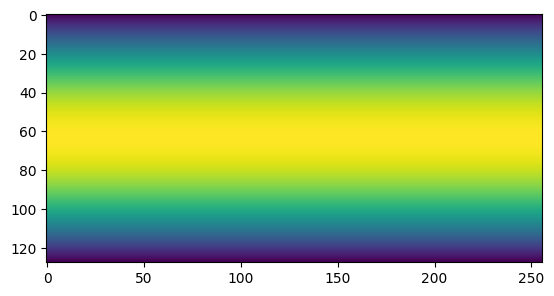

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(sineweight.reshape(128, 256).numpy())

In [24]:
import torch

axis_of_invariance = 2
conditioning = 'FiLM'
num_rays = 10
latent_dim = 5

Z = torch.randn(num_rays, latent_dim, 3)
D = torch.randn(num_rays, 3)

other_axes = [i for i in range(3) if i != axis_of_invariance]

# Select components along axes orthogonal to the axis of invariance
z_other = torch.stack((Z[:, :, other_axes[0]], Z[:, :, other_axes[1]]), -1) # [num_rays, latent_dim, 2]
d_other = torch.stack((D[:, other_axes[0]], D[:, other_axes[1]]), -1).unsqueeze(1) # [num_rays, 2]
d_other = d_other.expand_as(z_other) # size becomes [10, 5, 2]

# Invariant representation of Z, gram matrix G=Z*Z' is size num_rays x latent_dim x latent_dim
G = torch.bmm(z_other, torch.transpose(z_other, 1, 2))

# Flatten G to be size num_rays x latent_dim^2
z_other_invar = G.flatten(start_dim=1)

# Innerprod is size num_rays x latent_dim
innerprod = (z_other * d_other).sum(dim=-1) # [num_rays, latent_dim]

# Compute norm along the axes orthogonal to the axis of invariance
d_other_norm = torch.sqrt(D[::, other_axes[0]] ** 2 + D[:, other_axes[1]] ** 2).unsqueeze(-1) # [num_rays, 1]

# Get invariant component of Z along the axis of invariance 
z_invar = Z[:, :, axis_of_invariance] # [num_rays, latent_dim]

# Get invariant component of D along the axis of invariance
d_invar = D[:, axis_of_invariance].unsqueeze(-1) # [num_rays, 1]

if conditioning == "FiLM":
    model_input = torch.cat((d_other_norm, d_invar, innerprod), 1)  # [num_rays, 2 + ndims]
    conditioning_input = torch.cat((z_other_invar, z_invar), 1)  # [num_rays, ndims^2 + ndims]

if conditioning == "Concat":
    # model_input is size [num_rays, 2 x ndims + ndims^2 + 2]
    model_input = torch.cat((innerprod, z_other_invar, d_other_norm, z_invar, d_invar), 1)


z_other torch.Size([10, 5, 2])
d_other torch.Size([10, 5, 2])
G torch.Size([10, 5, 5])
z_other_invar torch.Size([10, 25])
innerprod torch.Size([10, 5])
d_other_norm torch.Size([10, 1])
z_invar torch.Size([10, 5])
d_invar torch.Size([10, 1])
model_input torch.Size([10, 7])
conditioning_input torch.Size([10, 30])


In [ ]:
z_other